# Section 1: LLM Ovveview

## LLM Pretraining
LLM is pre-trained to predict the next word.

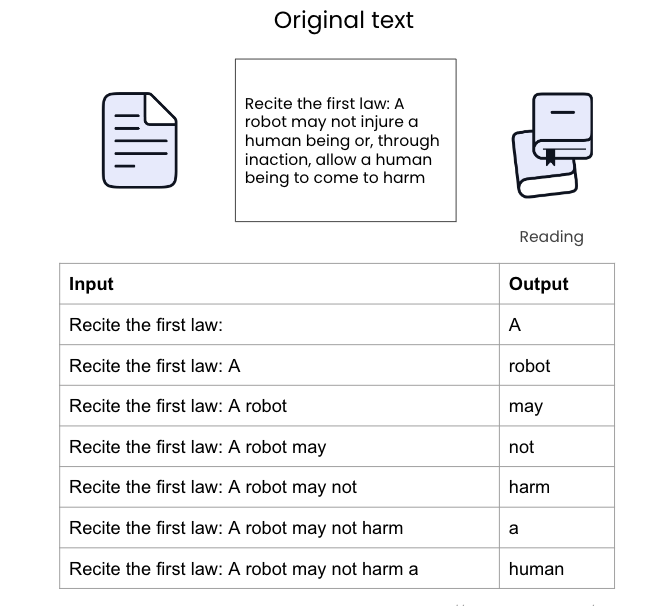

As the size increases, it becomes amazing. However, it is only good at predicting the next word.

`How's the weather today?`
-->
`How's the weather today? and tomorrow?`


## Instruction finetuning

Train the LLM to follow instructions beyond predicting the next word. This changes everything. Now, the LLM can follow your orders.

![image.png](attachment:image.png | width=100)

In [37]:
! pip3 install -qU openai langchain_community tiktoken langchain-upstage langchainhub faiss-cpu langchain python-dotenv

498.35s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [38]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [39]:
import os
from openai import OpenAI
from pprint import pprint

client = OpenAI(api_key=os.environ["UPSTAGE_API_KEY"], base_url="https://api.upstage.ai/v1/solar")
response = client.chat.completions.create(
            model="solar-1-mini-chat",
            messages=[
               {"role": "user", "content": "Hello, Solar!"},
            ],
        )
pprint(response)

ChatCompletion(id='9ccb40f4-e09a-44c7-9556-9f920faf18d3', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Hello! How can I assist you today?', role='assistant', function_call=None, tool_calls=None))], created=1714328546, model='upstage/solar-1-mini-chat-ko-0108', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=14, total_tokens=24))


In [40]:
client = OpenAI(api_key=os.environ["UPSTAGE_API_KEY"], base_url="https://api.upstage.ai/v1/solar")
response = client.chat.completions.create(
            model="solar-1-mini-chat",
            messages=[
               {"role": "user", "content": "Hello, Solar!"},
            ],
            stream=True
        )
pprint(response)

In [46]:
from langchain_upstage import (
    UpstageLayoutAnalysisLoader,
    UpstageGroundednessCheck,
    ChatUpstage,
    UpstageEmbeddings,
)
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter


layzer = UpstageLayoutAnalysisLoader("./sample.pdf", split="page")
# For improved memory efficiency, consider using the lazy_load method to load documents page by page.
docs = layzer.load()  # or layzer.lazy_load()

# Split
text_splitter = RecursiveCharacterTextSplitter(
chunk_size=500, chunk_overlap=100
)
splits = text_splitter.split_documents(docs)

ImportError: cannot import name 'UpstageLayoutAnalysisLoader' from 'langchain_upstage' (/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/langchain_upstage/__init__.py)

In [45]:
# Embed
vectorstore = FAISS.from_documents(
    documents=splits, embedding=UpstageEmbeddings()
)

retriever = vectorstore.as_retriever(k=10)

NameError: name 'splits' is not defined

In [ ]:
from langchain_upstage import ChatUpstage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

def query_expander(query):
    # Multi Query: Different Perspectives
    multi_query_template = """You are an AI language model assistant. Your task is to generate five 
    different versions of the given user question to retrieve relevant documents from a vector 
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search. 
    Provide these alternative questions separated by newlines. Original question: {query}"""

    # RAG-Fusion: Related
    rag_fusion_template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
    Generate multiple search queries related to: {query} \n
    Output (4 queries):"""

    # Decomposition
    decomposition_template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
    The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
    Generate multiple search queries related to: {query} \n
    Output (3 queries):"""

    query_expander_templates = [
        multi_query_template,
        rag_fusion_template,
        decomposition_template,
    ]

    expanded_queries = []
    for template in query_expander_templates:
        prompt_perspectives = ChatPromptTemplate.from_template(template)

        generate_queries = (
            prompt_perspectives
            | ChatUpstage(temperature=0)
            | StrOutputParser()
            | (lambda x: x.split("\n"))
        )
        expanded_queries += generate_queries.invoke({"query": query})

    return expanded_queries

expanded_queries = query_expander("What is the DUS approach developed by Upstage?")
pprint(expanded_queries)

['1. What is the Upstage DUS approach and how does it work?',
 '2. Can you explain the DUS approach developed by Upstage?',
 "3. I'm interested in learning about the DUS approach created by Upstage. Can "
 'you provide more information?',
 '4. Could you give me an overview of the DUS approach developed by Upstage?',
 '5. What are the key features of the DUS approach developed by Upstage?',
 '1. What are the key components of the DUS approach developed by Upstage?',
 '2. How does the DUS approach by Upstage differ from other user experience '
 'design methods?',
 '3. What are the benefits of using the DUS approach in user experience '
 'design?',
 '4. Can you provide examples of successful implementations of the DUS '
 'approach by Upstage?',
 '1. "What is the DUS approach developed by Upstage?"',
 '2. "What are the key components of the DUS approach developed by Upstage?"',
 '3. "How does the DUS approach developed by Upstage differ from other '
 'approaches in the field?"']


In [ ]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # Get unique documents
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]

In [ ]:
def retriever_multiple_queries(retriever, queries):
    all_docs = []
    for query in queries:
        docs = retriever.invoke({"query": query})
        all_docs.append(docs)

    unique_docs = get_unique_union(all_docs)
    return unique_docs
